# Причиность

## Библиотеки

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt

from statsmodels.regression.linear_model import OLS
from causalgraphicalmodels import CausalGraphicalModel

import statsmodels.api as sm

from causality.inference.search import IC
from causality.inference.independence_tests import MutualInformationTest
import pandas as pd
import seaborn as sns

from causality.estimation.adjustments import AdjustForDirectCauses
from causality.estimation.nonparametric import CausalEffect

## Warmup

### Связь в линейной регрессии

#### Fork

Смоделируем зависимости,соответствующие типу Fork.

Заметим, что здесь есть только одна переменная, которая является экзогенной (Z), то есть она не зависит ни от какой другой переменной в системе (не зависит от X, Y, эндогенных переменных).

$$Z->X, Z->Y, X->Y$$

![title](data/fork.png)

In [5]:
rs = np.random.RandomState(42)
N = 10000
Z = rs.randn(10000)
X = 0.5 * Z + rs.randn(10000) 
Y = 0.3 * Z + 0.4 * X + rs.randn(10000)

Построим разные регрессии регрессии Y ~ X, Y ~ Z + X, Y ~ Z. Что можно сказать о 95% доверительном интервале (confint) на коэффициент регрессии перед X в двух этих моделях?

In [6]:
l1 = OLS(Y, np.vstack([X]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.263
Model:                            OLS   Adj. R-squared (uncentered):              0.263
Method:                 Least Squares   F-statistic:                              3564.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:51:52   Log-Likelihood:                         -14486.
No. Observations:               10000   AIC:                                  2.897e+04
Df Residuals:                    9999   BIC:                                  2.898e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5511      0.009     59.699      0.000       0.533       0.569
==============================================================================
Omnibus:                        0.062   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.969   Jarque-Bera (JB):                0.051
Skew:                          -0.004   Prob(JB):                        0.975
Kurtosis:                       3.007   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

То есть можно вппроксимировать $Y = 0.53 \cdot X$. Или типа того.

In [7]:
l1 = OLS(Y, np.vstack([X, Z]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.318
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              2331.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:51:53   Log-Likelihood:                         -14096.
No. Observations:               10000   AIC:                                  2.820e+04
Df Residuals:                    9998   BIC:                                  2.821e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4266      0.010     43.099      0.000       0.407       0.446
x2             0.3134      0.011     28.467      0.000       0.292       0.335
==============================================================================
Omnibus:                        3.320   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                3.163
Skew:                           0.007   Prob(JB):                        0.206
Kurtosis:                       2.914   Cond. No.                         1.63
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Аналогично получаем для аппроксимации сразу $X$ и $Z$.

In [8]:
l1 = OLS(Y, np.vstack([Z]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.191
Model:                            OLS   Adj. R-squared (uncentered):              0.191
Method:                 Least Squares   F-statistic:                              2366.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:51:54   Log-Likelihood:                         -14948.
No. Observations:               10000   AIC:                                  2.990e+04
Df Residuals:                    9999   BIC:                                  2.991e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5230      0.011     48.641      0.000       0.502       0.544
==============================================================================
Omnibus:                       12.818   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.305
Skew:                           0.029   Prob(JB):                      0.00351
Kurtosis:                       2.846   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Аналогично для аппроксимации только $Z$. Следовательно, получаем, такой же результат, как при арифметической постановке в изначальных формулах.

**Вывод**: вилка позволяет избавиться от 1 переменной.

### Collider

Рассмотрим collider:
```
X -> Z
X -> Y
Y -> Z
```

![title](data/collider.png)

In [9]:
X = rs.randn(N)
Y = 0.7 * X + rs.randn(N)
Z = 1.2 * X + 0.6 * Y + rs.randn(N)

In [10]:
l1 = OLS(Y, np.vstack([X]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.336
Model:                            OLS   Adj. R-squared (uncentered):              0.336
Method:                 Least Squares   F-statistic:                              5053.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:52:03   Log-Likelihood:                         -14193.
No. Observations:               10000   AIC:                                  2.839e+04
Df Residuals:                    9999   BIC:                                  2.839e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7079      0.010     71.083      0.000       0.688       0.727
==============================================================================
Omnibus:                        3.522   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                3.548
Skew:                          -0.045   Prob(JB):                        0.170
Kurtosis:                       2.978   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
l1 = OLS(Y, np.vstack([X, Z]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.504
Model:                            OLS   Adj. R-squared (uncentered):              0.504
Method:                 Least Squares   F-statistic:                              5084.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:52:13   Log-Likelihood:                         -12730.
No. Observations:               10000   AIC:                                  2.546e+04
Df Residuals:                    9998   BIC:                                  2.548e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0107      0.015      0.725      0.468      -0.018       0.040
x2             0.4311      0.007     58.298      0.000       0.417       0.446
==============================================================================
Omnibus:                        0.285   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.867   Jarque-Bera (JB):                0.269
Skew:                          -0.012   Prob(JB):                        0.874
Kurtosis:                       3.010   Cond. No.                         4.02
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Непонятно, почему у $X$ коэффцициент ~0.

Так происходит потому, что $Z$ генерируется из $X$ и $Y$, и вся информация об $X$ уже сокрыта в $Y$.

In [12]:
l1 = OLS(Y, np.vstack([Z]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.504
Model:                            OLS   Adj. R-squared (uncentered):              0.504
Method:                 Least Squares   F-statistic:                          1.017e+04
Date:                Sat, 24 Apr 2021   Prob (F-statistic):                        0.00
Time:                        21:59:15   Log-Likelihood:                         -12730.
No. Observations:               10000   AIC:                                  2.546e+04
Df Residuals:                    9999   BIC:                                  2.547e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4355      0.004    100.838      0.000       0.427       0.444
==============================================================================
Omnibus:                        0.272   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.873   Jarque-Bera (JB):                0.256
Skew:                          -0.011   Prob(JB):                        0.880
Kurtosis:                       3.010   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ответы совпали с предыдущей аппроксимацией, как и предполагалось.

**Прикладные задачи типа вилка**:
 - $X$ — объем продаж мороженого
 - $Y$ — число пожаров в лесах
 - $Z$ — время года
 
 
 **Прикладные задачи типа колайдер**:
 - $X$ — время года
 - $Y$ — число людей, которые выходят на пикник
 - $Z$ — число пожаров в лесах

### DAGs (Directed Acyclic Graphs)

#### Рассмотрим простой граф

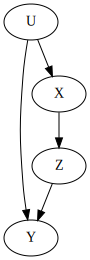

In [13]:
G = CausalGraphicalModel(nodes=['U', 'Z', 'X', 'Y'], edges=[
    ('U', 'Y'),
    ('U', 'X'),
    ('X', 'Z'),
    ('Z', 'Y')
])
G.draw()

#### Найдем все пути в графе (без циклов)

method — all_simple_paths

In [14]:
list(nx.all_simple_paths(G.dag, 'X', 'Y'))

[['X', 'Z', 'Y']]

#### Все пути, если считать граф не ориентированным

In [15]:
list(nx.all_simple_paths(G.dag.to_undirected(), 'X', 'Y'))

[['X', 'U', 'Y'], ['X', 'Z', 'Y']]

#### Рассмотрим все зависимости

In [16]:
G.get_all_independence_relationships()

[('Y', 'X', {'U', 'Z'}), ('Z', 'U', {'X'})]

#### Сгенерим распределение

In [16]:
G.get_distribution()

'P(U)P(X|U)P(Z|X)P(Y|U,Z)'

#### Обусловимся на переменную $X$ == выкинуть связи, которые входят в $X$

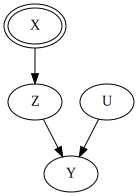

In [17]:
G.do('X').draw()

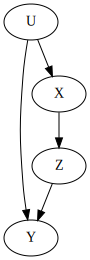

In [18]:
G.draw()

In [18]:
G.get_all_backdoor_adjustment_sets('Y','X')

frozenset({frozenset({'U', 'Z'})})

In [20]:
G.get_all_frontdoor_adjustment_sets('Y','X')

frozenset({frozenset()})

In [21]:
G.get_all_frontdoor_adjustment_sets('X','Y')

frozenset({frozenset({'Z'})})

## Inductive search

Допустим, у нас есть несколько событий:

1. Продажа мороженного (ICE)
2. Количество преступлений (CRIMES)
3. Количество полицейских на тысячу человек (POLICE)
4. Средняя температура (TEMP)
5. Количество скачиваний браузера IE (IE)
6. Количество зараженных компьютеров (COMP)
7. Уровень загрязнения воздуха (AIR)

P.S. Полная синтетика!

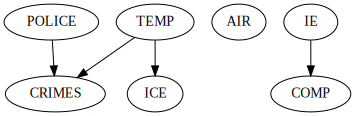

In [27]:
G = CausalGraphicalModel(nodes=['ICE','CRIMES','POLICE', 'TEMP','IE','COMP', 'AIR'], 
edges=[('TEMP','ICE'),  ('TEMP','CRIMES'), ('IE','COMP'), ('POLICE', 'CRIMES')])
G.draw()

In [28]:
rs = np.random.RandomState(42)
police = rs.uniform(low=1, high=100, size=1000)
temp = rs.uniform(low=-40, high=40, size=1000)
air = rs.uniform(size=1000)
crimes = (temp + 40) / police
ice = temp + 40
ie = rs.uniform(size=1000)
comp = ie**2
dataframe = pd.DataFrame({'police':police, 'temp':temp, 'air':air, 'crimes':crimes, 'ice':ice, 'ie':ie, 'comp':comp})

In [29]:
dataframe.sample(5)

,police,temp,air,crimes,ice,ie,comp
382,63.265342,37.552986,0.916635,1.225837,77.552986,0.031149,0.000970
125,43.283671,4.068590,0.667920,1.018134,44.068590,0.606732,0.368123
809,12.210567,-32.128348,0.718331,0.644659,7.871652,0.052765,0.002784
53,89.587908,23.902659,0.945698,0.713296,63.902659,0.287462,0.082634
585,24.774416,-29.084820,0.624784,0.440583,10.915180,0.328233,0.107737


In [30]:
class OLS_test():
    def __init__(self, y, x, z, data, alpha):
        self.regression = sm.OLS.from_formula('{0}~{1}'.format(y[0], '+'.join(x + z)), data)
        self.result = self.regression.fit()
        self.x = x
        self.y = y
        self.z = z
        self.alpha = alpha
        print(y, x, z)

    def independent(self):
        to_fisher = '(' + ' ,'.join([x_ + '=0' for x_ in self.x]) + ')'
        return self.result.f_test(to_fisher).pvalue > self.alpha

In [31]:
variable_types = {'police' : 'd', 
                  'temp' : 'd',
                  'air' : 'c',
                  'ice' : 'd',
                  'crimes' : 'd',
                  'ie':'c',
                  'comp':'c'}

ic_algorithm = IC(OLS_test, alpha=0.05)
graph = ic_algorithm.search(dataframe, variable_types)

AttributeError: 'Graph' object has no attribute 'node'

In [29]:
nx.draw_networkx(graph)

NameError: name 'graph' is not defined

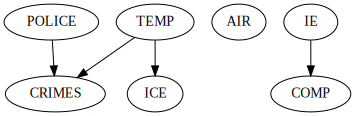

In [24]:
G = CausalGraphicalModel(nodes=['ICE','CRIMES','POLICE', 'TEMP','IE','COMP', 'AIR'], 
edges=[('TEMP','ICE'),  ('TEMP','CRIMES'), ('IE','COMP'), ('POLICE', 'CRIMES')])
G.draw()

In [31]:
for e in graph.edges(data=True):
    print(e)

NameError: name 'graph' is not defined

## Задача про курение

In [32]:
smoke = []
cancer = []
tar = []

smoke += [1] * 323
cancer += [0]*323
tar+=[1]*323

smoke+=[0]
cancer+=[0]
tar+=[1]

smoke+=[1]*57
cancer+=[1]*57
tar+=[1]*57

smoke+=[0]*19
cancer+=[1]*19
tar+=[1]*19


smoke+=[1]*18
cancer+=[0]*18
tar+=[0]*18

smoke+=[0]*38
cancer+=[0]*38
tar+=[0]*38

smoke+=[1]*2
cancer+=[1]*2
tar+=[0]*2

smoke+=[0]*342
cancer+=[1]*342
tar+=[0]*342

dataframe = pd.DataFrame({'smoke':smoke, 'tar':tar, 'cancer':cancer})
dataframe.sample(5)

,smoke,tar,cancer
83,1,1,0
392,0,1,1
49,1,1,0
597,0,0,1
367,1,1,1


### Строим граф

In [33]:
g = nx.DiGraph()

In [34]:
g.add_nodes_from(['smoke','cancer','tar'])
g.add_edges_from([('tar','cancer'),('smoke','tar')])

Matplotlib is building the font cache; this may take a moment.


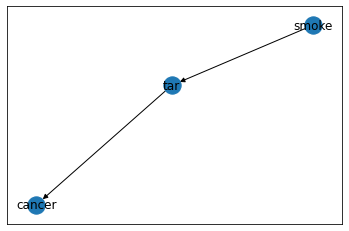

In [35]:
nx.draw_networkx(g)

### Иследуем причинность

In [36]:
adjustment = AdjustForDirectCauses()
admissable_set = adjustment.admissable_set(g,['tar'], ['cancer'])
admissable_set

{'smoke'}

In [37]:
dataframe.columns

Index(['smoke', 'tar', 'cancer'], dtype='object')

In [38]:
effect = CausalEffect(dataframe.sample(299), ['smoke'], ['cancer'], 
                      variable_types={'smoke': 'u', 'cancer': 'u', 'tar': 'u'},
                      admissable_set=[])

In [39]:
smoke = pd.DataFrame({'smoke': [1], 'cancer': [1]})
nsmoke = pd.DataFrame({'smoke': [0], 'cancer': [1]})

In [40]:
effect.pdf(smoke) - effect.pdf(nsmoke)

-0.49561380570763863